### To Change to Uplow update these following
- /home/epinyoan/git/momask-codes/models/mask_transformer/transformer_trainer.py
- /home/epinyoan/git/momask-codes/models/vq/model.py
- /home/epinyoan/git/momask-codes/models/mask_transformer/transformer.py

### T2M-GPT Transformer change these:
from 2024-01-19-20-40-27_2_GPT_randId0-.5_weightBySample_t2mgptTrans_logEvry50_n_layers4
- /models/mask_transformer/tools.py (only one line: just don't compute loss here)
- /models/mask_transformer/transformer.py


In [1]:
import sys
sys.path.append('../')
import os
os.chdir('../')
%reload_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
%matplotlib notebook
%matplotlib inline
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [2]:
import os
import torch
import numpy as np

from torch.utils.data import DataLoader
from os.path import join as pjoin

from models.mask_transformer.transformer import MaskTransformer
from models.mask_transformer.transformer_trainer import MaskTransformerTrainer
from models.vq.model import RVQVAE

from options.train_option import TrainT2MOptions

from utils.plot_script import plot_3d_motion
from utils.motion_process import recover_from_ric
from utils.get_opt import get_opt
from utils.fixseed import fixseed
from utils.paramUtil import t2m_kinematic_chain, kit_kinematic_chain

from data.t2m_dataset import Text2MotionDataset
from motion_loaders.dataset_motion_loader import get_dataset_motion_loader
from models.t2m_eval_wrapper import EvaluatorModelWrapper
from exit.utils import visualize_2motions

/home/epinyoan/miniconda3/envs/momask/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
from options.train_option import TrainT2MOptions
parser = TrainT2MOptions()
opt = parser.parse(is_mock=True)
opt.name

------------ Options -------------
batch_size: 64
checkpoints_dir: ./log/t2m
cond_drop_prob: 0.1
dataset_name: t2m
dropout: 0.2
eval_every_e: 10
ff_size: 1024
force_mask: False
gamma: 0.1
gpu_id: -1
gumbel_sample: False
is_continue: False
is_train: True
latent_dim: 384
log_every: 50
lr: 0.0002
max_epoch: 500
max_motion_length: 196
milestones: [50000]
n_heads: 6
n_layers: 8
name: 2024-02-24-16-09-49_t2m_nlayer8_nhead6_ld384_ff1024_cdp0.1_rvq6ns
save_latest: 500
seed: 3407
share_weight: False
trans: official
unit_length: 4
vq_name: rvq_nq1_dc512_nc512
warm_up_iter: 2000
-------------- End ----------------


'2024-02-24-16-09-49_t2m_nlayer8_nhead6_ld384_ff1024_cdp0.1_rvq6ns'

In [4]:
opt.data_root = './dataset/HumanML3D'
opt.motion_dir = pjoin(opt.data_root, 'new_joint_vecs')
opt.joints_num = 22
opt.max_motion_len = 55
dim_pose = 263
radius = 4
fps = 20
kinematic_chain = t2m_kinematic_chain
dataset_opt_path = './checkpoints/t2m/Comp_v6_KLD005/opt.txt'


In [5]:
opt.vq_name = 'rvq_nq6_dc512_nc512_noshare_qdp0.2'
vq_opt = get_opt(f'/home/epinyoan/git/momask-codes/checkpoints/t2m/{opt.vq_name}/opt.txt', 'cuda')
vq_model = RVQVAE(vq_opt,
                dim_pose,
                vq_opt.nb_code,
                vq_opt.code_dim,
                vq_opt.output_emb_width,
                vq_opt.down_t,
                vq_opt.stride_t,
                vq_opt.width,
                vq_opt.depth,
                vq_opt.dilation_growth_rate,
                vq_opt.vq_act,
                vq_opt.vq_norm)
ckpt = torch.load(pjoin(vq_opt.checkpoints_dir, vq_opt.dataset_name, vq_opt.name, 'model', 'net_best_fid.tar'),
                        map_location='cpu')
model_key = 'vq_model' if 'vq_model' in ckpt else 'net'
vq_model.load_state_dict(ckpt[model_key])
print(f'Loading VQ Model {opt.vq_name}')

Reading /home/epinyoan/git/momask-codes/checkpoints/t2m/rvq_nq6_dc512_nc512_noshare_qdp0.2/opt.txt


Loading VQ Model rvq_nq6_dc512_nc512_noshare_qdp0.2


In [6]:
opt.log_dir = pjoin('./log/t2m/', opt.dataset_name, opt.name)
opt.device = 'cuda' #torch.device("cpu" if opt.gpu_id == -1 else "cuda:" + str(opt.gpu_id))
opt.text_dir = pjoin(opt.data_root, 'texts')
opt.num_tokens = vq_opt.nb_code
clip_version = 'ViT-B/32'
# opt.trans = 't2mgpt'
opt.trans = 'official'

t2m_transformer = MaskTransformer(code_dim=vq_opt.code_dim,
                                      cond_mode='text',
                                      latent_dim=opt.latent_dim,
                                      ff_size=opt.ff_size,
                                      num_layers=opt.n_layers,
                                      num_heads=opt.n_heads,
                                      dropout=opt.dropout,
                                      clip_dim=512,
                                      cond_drop_prob=opt.cond_drop_prob,
                                      clip_version=clip_version,
                                      opt=opt)
# t2m_transformer.load_and_freeze_token_emb(vq_model.quantizer_upper.codebooks[0], vq_model.quantizer_lower.codebooks[1])

latent_dim: 384, ff_size: 1024, nlayers: 8, nheads: 6, dropout: 0.2
Loading CLIP...


In [7]:
# model_dir = '/home/epinyoan/git/momask-codes/log/t2m/t2m/2024-01-18-23-27-31_2_GPT_randId0-.5_weightBySample/model/latest.tar'
# model_dir = '/home/epinyoan/git/momask-codes/log/t2m/t2m/2024-01-21-09-10-30_3_GPT_randId0-.5_weightBySample_FIXED_TRAIN_END_TOKEN_b256/model/latest.tar'

model_dir = '/home/epinyoan/git/momask-codes/log/t2m/t2m/2024-01-21-15-58-00_3_GPT_randId0-.5_weightBySample_b256_mile50k80k_ep1k/model/net_best_fid.tar'
# model_dir = '/home/epinyoan/git/momask-codes/log/t2m/t2m/2024-01-21-18-23-51_3_GPT_randId0-.5_weightBySample_b512_mile50k80k_ep2k/model/net_best_fid.tar'
# model_dir = '/home/epinyoan/git/momask-codes/log/t2m/t2m/2024-01-23-11-55-04_4_GPT_randId0-.5_weightBySample_b256_mile50k80k_ep1k_EndTokenAttn_test_gpt/model/net_best_fid.tar'
model_dir = '/home/epinyoan/git/momask-codes/log/t2m/t2m/2024-02-06-15-08-00_5_GPT_ref-end-3_cond.5rand0-.5_lossMaskOnlyWeigthEqual_noPredEnd_FIXCOND/model/net_best_fid.tar'
model_dir = '/home/epinyoan/git/momask-codes/log/t2m/t2m/2024-02-14-14-27-29_8_GPT_officialTrans_2iterPrdictEnd/model/net_best_fid.tar'
checkpoint = torch.load(model_dir, map_location='cuda')
missing_keys, unexpected_keys = t2m_transformer.load_state_dict(checkpoint['t2m_transformer'], strict=False)

In [9]:
mean = np.load(pjoin('./checkpoints/', opt.dataset_name, opt.vq_name, 'meta', 'mean.npy'))
std = np.load(pjoin('./checkpoints/', opt.dataset_name, opt.vq_name, 'meta', 'std.npy'))

train_split_file = pjoin(opt.data_root, 'train.txt')
val_split_file = pjoin(opt.data_root, 'val.txt')

train_dataset = Text2MotionDataset(opt, mean, std, train_split_file)
val_dataset = Text2MotionDataset(opt, mean, std, val_split_file)

train_loader = DataLoader(train_dataset, batch_size=opt.batch_size, num_workers=4, shuffle=True, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=opt.batch_size, num_workers=4, shuffle=True, drop_last=True)

eval_val_loader, _ = get_dataset_motion_loader(dataset_opt_path, 32, 'val', device=opt.device)

wrapper_opt = get_opt(dataset_opt_path, torch.device('cuda'))
eval_wrapper = EvaluatorModelWrapper(wrapper_opt)


 65%|██████▍   | 15156/23384 [00:05<00:02, 3145.65it/s]

100%|██████████| 1460/1460 [00:17<00:00, 85.21it/s] 


Reading ./checkpoints/t2m/Comp_v6_KLD005/opt.txt
Loading dataset t2m ...


100%|██████████| 1460/1460 [00:00<00:00, 2640.84it/s]


Pointer Pointing at 0
Ground Truth Dataset Loading Completed!!!
Reading ./checkpoints/t2m/Comp_v6_KLD005/opt.txt
Loading Evaluation Model Wrapper (Epoch 28) Completed!!


### Train

In [10]:
opt.is_train = False # to turn of tensorboard
trainer = MaskTransformerTrainer(opt, t2m_transformer, vq_model)
# trainer.resume(model_dir = '/home/epinyoan/git/momask-codes/log/t2m/t2m/2024-01-13-22-25-36_1_uplow_vq512emb_mileStone100k_800ep/model/latest.tar')
# vq_model.moment = {'mean': torch.from_numpy(train_loader.dataset.mean).cuda().float(), 
#                 'std': torch.from_numpy(train_loader.dataset.std).cuda().float()}
t2m_transformer.to(opt.device)
vq_model.to(opt.device)
''

''

torch.Size([64])

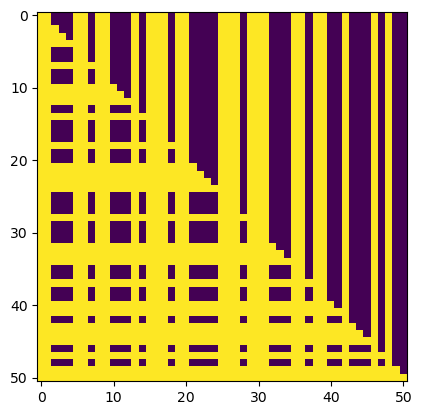

In [11]:
batch_data = next(iter(train_loader))
conds, motion, m_lens = batch_data
motion = motion.detach().float().to(opt.device)
m_lens = m_lens.detach().long().to(opt.device)

# (b, n, q)
code_idx, _ = vq_model.encode(motion)
m_lens = m_lens // 4

conds = conds.to(opt.device).float() if torch.is_tensor(conds) else conds

t2m_transformer.train()
_loss, _pred_ids, _acc = t2m_transformer(code_idx[..., 0], conds, m_lens)
_loss, _pred_ids.shape, _acc
plt.imshow(t2m_transformer.attn[0].detach().cpu(), cmap='viridis', interpolation='nearest')
m_lens.shape

In [ ]:
_loss, _pred_ids, _acc = t2m_transformer(code_idx[..., 0], conds, m_lens)

torch.Size([64])

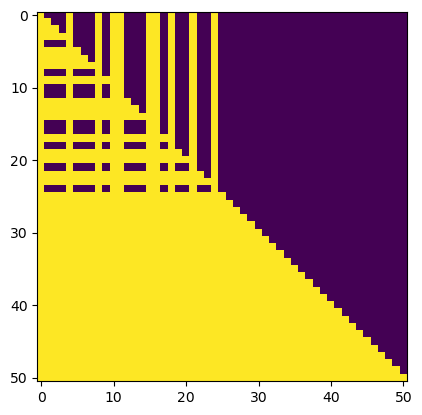

In [ ]:
_loss, _pred_ids, _acc = t2m_transformer(code_idx[..., 0], conds, m_lens)
plt.imshow(t2m_transformer.attn[0].detach().cpu(), cmap='viridis', interpolation='nearest')
m_lens.shape

In [ ]:
# Test "pad_when_end"
xs = torch.tensor([[1,2,3,4,5,6],
                   [1,2,3,4,512,512],
                   [1,512,3,4,5,512],
                   [512,2,3,4,5,6],], device='cuda')
t2m_transformer.pad_when_end(xs)

(tensor([[ 1,  2,  3,  4,  5,  6],
         [ 1,  2,  3,  4, -1, -1],
         [ 1, -1, -1, -1, -1, -1],
         [ 0, -1, -1, -1, -1, -1]], device='cuda:0'),
 tensor([7, 4, 1, 1], device='cuda:0'))

### Generate

In [ ]:
word_embeddings, pos_one_hots, clip_text, sent_len, pose, m_length, token = next(iter(eval_val_loader))
m_length = m_length.cuda()
time_steps = 3
cond_scale = 4
t2m_transformer.eval()
vq_model.eval()

pose = pose.detach().float().to(opt.device)
code_idx, _ = vq_model.encode(pose)

mids = t2m_transformer.generate(clip_text, m_length//4, time_steps, cond_scale, temperature=1) # , temp=code_idx[..., 0]
mids, pred_len = t2m_transformer.pad_when_end(mids)
mids.unsqueeze_(-1)
pred_motions = vq_model.forward_decoder(mids)

# k = 0
# x = pred_motions[k, :196].detach().cpu().numpy()
# l = pred_len[k]*4
# print(clip_text[k])
# visualize_2motions(x, val_loader.dataset.std, val_loader.dataset.mean, 't2m', l, pose[k].cpu().numpy())

tensor([3.7810e-02, 7.1936e-04, 7.8117e-01, 2.3134e-02, 5.7126e-02, 1.2578e-01,
        3.3669e-01, 1.6219e-01, 8.4504e-02, 3.3252e-01, 1.2331e-02, 2.5647e-01,
        1.1330e-01, 7.0758e-01, 4.1911e-02, 4.0030e-01, 1.7420e-01, 4.5490e-01,
        6.0039e-01, 2.6611e-01, 4.0945e-01, 3.7527e-01, 2.5226e-02, 4.3360e-01,
        2.5274e-02, 7.1662e-01, 1.1089e-01, 5.9045e-01, 1.0395e-01, 7.1237e-04,
        6.2982e-02, 4.3854e-02, 4.8928e-01, 6.9332e-01, 5.7859e-01, 7.7070e-01,
        7.0054e-02, 7.1324e-01, 8.7644e-01, 2.3750e-02, 6.8027e-01, 5.4855e-02,
        5.8607e-01, 4.3825e-01, 2.9914e-01, 2.2393e-01, 7.8849e-03, 1.6131e-01,
        6.2840e-01, 1.0000e+05], device='cuda:0')
tensor([513, 513, 491, 513, 513, 513, 451, 513, 513, 116, 513, 325, 513, 210,
        513, 225, 513, 290, 103, 500,  41,  91, 513, 487, 513,  56, 513,  56,
        513, 513, 513, 513, 444, 257,  41,  44, 513,  41, 331, 513,  41, 513,
        219, 219, 219, 513, 513, 513, 512, 513], device='cuda:0')


In [ ]:
pose.shape, pred_motions.shape

(torch.Size([32, 196, 263]), torch.Size([32, 200, 263]))

In [ ]:
torch.set_printoptions(sci_mode=False)
cond_scale = 1 # 4
# 0.3156, 0.4812, 0.4942, 0.4637, 0.4258, 0.3843, 0.3376, 0.2656
time_steps = 10
idx = t2m_transformer.generate(clip_text, m_length//4, time_steps, cond_scale, temperature=1) # , temp=code_idx[..., 0]
# plt.imshow(~t2m_transformer.attn[0, 0].detach().cpu(), cmap='viridis', interpolation='nearest')
# m_length//4

tensor([    0.0256,     0.0082,     0.1570,     0.2535,     0.3287,     0.5966,
            0.0306,     0.1090,     0.1167,     0.0239,     0.0204,     0.3118,
            0.2005,     0.5239,     0.6631,     0.5328,     0.2145,     0.0107,
            0.0016,     0.1923,     0.7871,     0.4206,     0.4051,     0.4193,
            0.7445,     0.0002,     0.1947,     0.5320,     0.1691,     0.4780,
            0.2369,     0.0004,     0.0090,     0.2788,     0.4168,     0.4561,
            0.6650,     0.7167,     0.6109,     0.0206,     0.3886,     0.5065,
            0.2271,     0.0431,     0.0038,     0.5368,     0.6456,     0.2781,
            0.1156,     1.0000], device='cuda:0')
tensor([513, 513, 513, 513,  41, 331, 513, 513, 513, 513, 513, 101, 513, 416,
        416, 416, 513, 513, 513, 513, 187, 187, 187, 296, 129, 513, 513,  23,
        513,  48, 513, 513, 513, 450, 254, 254,  88, 290, 290, 513, 444, 257,
        513, 513, 513,  41, 331, 211, 513, 512], device='cuda:0')


### Eval

In [ ]:
from utils.eval_t2m import evaluation_mask_transformer
class LoggerWriterMock:
    def __init__(self):
        self.info
    def info(self, *args):
        print(*args)
    def add_scalar(self, *args):
        print(*args)
    def add_video(self, *args):
        print(*args)
logger = LoggerWriterMock()
best_fid, best_div, best_top1, best_top2, best_top3, best_matching, writer = evaluation_mask_transformer(
        'opt.save_root', eval_val_loader, t2m_transformer, vq_model, logger, 0,
        best_fid=100, best_div=100,
        best_top1=0, best_top2=0, best_top3=0,
        best_matching=100, eval_wrapper=eval_wrapper,
        plot_func=lambda x:x, save_ckpt=False, save_anim=False
    )

  0%|          | 0/47 [00:00<?, ?it/s]

100%|██████████| 47/47 [00:50<00:00,  1.06s/it]


--> 	 Eva. Ep 0 :, FID. 0.1020, Diversity Real. 9.5366, Diversity. 10.1449, R_precision_real. [0.53257979 0.71409574 0.8018617 ], R_precision. [0.50531915 0.68617021 0.7912234 ], matching_score_real. 2.9433668167033096, matching_score_pred. 3.0314616954072995
./Test/FID 0.10198047658796838 0
./Test/Diversity 10.144877 0
./Test/top1 0.5053191489361702 0
./Test/top2 0.6861702127659575 0
./Test/top3 0.7912234042553191 0
./Test/matching_score 3.0314616954072995 0
--> --> 	 FID Improved from 100.00000 to 0.10198 !!!
--> --> 	 matching_score Improved from 100.00000 to 3.03146 !!!
--> --> 	 Diversity Improved from 100.00000 to 10.14488 !!!
--> --> 	 Top1 Improved from 0.0000 to 0.5053 !!!
--> --> 	 Top2 Improved from 0.0000 to 0.6862 !!!
--> --> 	 Top3 Improved from 0.0000 to 0.7912 !!!


### Edit

In [30]:
__break__ = False
while __break__ is False:
    for word_embeddings, pos_one_hots, clip_text, sent_len, pose, m_length, token in eval_val_loader:
        for i, text in enumerate(clip_text):
            # if True: #'cartwheel' in text:
            # if 'a person walks forward then turns completely around and does a cartwheel.' in text:
            # if 'a person who is standing moves his body and shoulders slightly to the left and returns to his original position.' in text:
            # if 'person carefully kneels down. first with right leg, then with the left one.' in text:
            # if 'a person walks forward then turns completely around and does a cartwheel.' in text:
            # if 'a person with their arms out from their sides, walks to the left trying to balance.' in text:
            # if 'a person walks forward, then is pushed to their left and then returns to walking in the line they were.' in text:
            if 'treadmill' in text:
                __break__ = True
                print(i, m_length[i], text)
                break
        if __break__:
            break
# m_length = m_length[i:i+1].cuda()
# base_pose = pose[i:i+1].cuda()

''

24 tensor(192) the person is walking on the treadmill.


''

In [31]:
k = i
x = pose[k].detach().cpu().numpy()
l = m_length[k]
visualize_2motions(x, val_loader.dataset.std, val_loader.dataset.mean, 't2m', l)

#### Inpainting

In [22]:
# word_embeddings, pos_one_hots, clip_text, sent_len, pose, m_length, token = next(iter(eval_val_loader))

bs, seq = pose.shape[:2]
tokens = t2m_transformer.pad_id * torch.ones((bs, 50), dtype=torch.long).cuda()
m_token_length = torch.ceil((m_length)/4).int().cpu().numpy()
m_token_length_init = (m_token_length * .25).astype(int)
m_length_init = (m_length * .25).int()
for k in range(bs):
    l = m_length_init[k]
    l_token = m_token_length_init[k]

    # # start tokens
    index_motion, _ = vq_model.encode(pose[k:k+1, :l].cuda())
    index_motion = index_motion[..., 0]
    tokens[k,:index_motion.shape[1]] = index_motion[0]

    # # end tokens
    index_motion, _ = vq_model.encode(pose[k:k+1, m_length[k]-l :m_length[k]].cuda())
    index_motion = index_motion[..., 0]
    tokens[k, m_token_length[k]-l_token :m_token_length[k]] = index_motion[0]

#### Outpainting

In [81]:
# word_embeddings, pos_one_hots, clip_text, sent_len, pose, m_length, token = next(iter(eval_val_loader))

bs, seq = pose.shape[:2]
tokens = t2m_transformer.pad_id * torch.ones((bs, 50), dtype=torch.long).cuda()
m_token_length = torch.ceil((m_length)/4).int().cpu().numpy()
m_token_length_init = (m_token_length * .25).astype(int)
m_length_init = (m_length * .25).int()
for k in range(bs):
    l = m_length_init[k]
    l_token = m_token_length_init[k]

    # # inside tokens
    index_motion, _ = vq_model.encode(pose[k:k+1, l:m_length[k]-l].cuda())
    index_motion = index_motion[..., 0]
    tokens[k, l_token: l_token+index_motion.shape[1]] = index_motion[0]

#### prefix

In [95]:
# word_embeddings, pos_one_hots, clip_text, sent_len, pose, m_length, token = next(iter(eval_val_loader))

bs, seq = pose.shape[:2]
tokens = t2m_transformer.pad_id * torch.ones((bs, 50), dtype=torch.long).cuda()
m_token_length = torch.ceil((m_length)/4).int().cpu().numpy()
m_token_length_half = (m_token_length * .5).astype(int)
m_length_half = (m_length * .5).int()
for k in range(bs):
    # # prefix tokens
    index_motion, _ = vq_model.encode(pose[k:k+1, :m_length_half[k]].cuda())
    index_motion = index_motion[..., 0]
    tokens[k, :m_token_length_half[k]] = index_motion[0]

#### Suffix

In [97]:
# word_embeddings, pos_one_hots, clip_text, sent_len, pose, m_length, token = next(iter(eval_val_loader))

bs, seq = pose.shape[:2]
tokens = t2m_transformer.pad_id * torch.ones((bs, 50), dtype=torch.long).cuda()
m_token_length = torch.ceil((m_length)/4).int().cpu().numpy()
m_token_length_half = (m_token_length * .5).astype(int)
m_length_half = (m_length * .5).int()
for k in range(bs):
    # # suffic tokens
    index_motion, _ = vq_model.encode(pose[k:k+1, m_length_half[k]:m_length[k]].cuda())
    index_motion = index_motion[..., 0]
    tokens[k, m_token_length[k]-m_token_length_half[k] :m_token_length[k]] = index_motion[0]

In [100]:

mids = t2m_transformer.edit2(['A person does a cartwheel.']*tokens.shape[0], tokens)
mids, pred_len = t2m_transformer.pad_when_end(mids)
mids.unsqueeze_(-1)
pred_motions = vq_model.forward_decoder(mids)

k = i
x = pred_motions[k].detach().cpu().numpy()
l = m_length[k]
caption = text[k]
visualize_2motions(x, val_loader.dataset.std, val_loader.dataset.mean, 't2m', l)

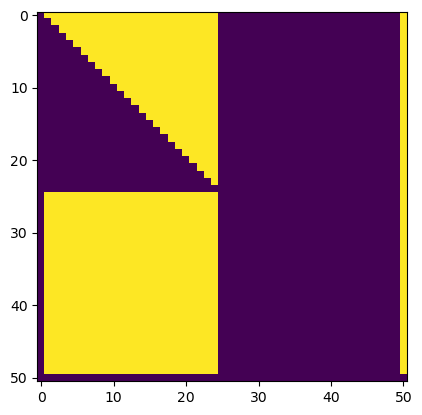

In [ ]:
plt.imshow(~t2m_transformer.attn[0].detach().cpu(), cmap='viridis', interpolation='nearest')

### Mask
Pytorch transformer support both float and bool

In [ ]:
# 1. float version
# [[0., -inf, -inf],
# [0., 0., -inf],
# [0., 0., 0.]]
# https://discuss.pytorch.org/t/how-to-add-padding-mask-to-nn-transformerencoder-module/63390
# def src_mask(self, sz):
#     mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
#     mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
#     return mask

# 2. bool or int version
# [[False,  True,  True],
# [False, False,  True],
# [False, False, False]]

In [ ]:
# https://pytorch.org/tutorials/beginner/transformer_tutorial.html
# https://github.com/pytorch/pytorch/blob/main/torch/nn/modules/transformer.py#L31
sz = 3
mask_float = torch.triu(
        torch.full((sz, sz), float('-inf'), dtype=float),
        diagonal=1,
    )


# https://github.com/pytorch/pytorch/blob/main/torch/nn/functional.py#L5142
mask_bool = torch.tril(torch.ones(sz, sz))<1
mask = (
    torch.zeros_like(mask_bool, dtype=float)
    .masked_fill_(mask_bool, float("-inf"))
)
mask, mask_float
mask_bool

tensor([[False,  True,  True],
        [False, False,  True],
        [False, False, False]])

### Study Mask Attention in Pytorch Transformer Encoder
[DELETE This]: already figured out that mask attn for end token (cond tokens) need to rm causal attn.

In [ ]:
import torch.nn.functional as F
import torch.optim as optim
from models.mask_transformer.transformer import PositionalEncoding
class MaskTransformer(torch.nn.Module):
    def __init_weights(self, module):
        if isinstance(module, (torch.nn.Linear, torch.nn.Embedding)):
            module.weight.data.normal_(mean=0.0, std=0.02)
            if isinstance(module, torch.nn.Linear) and module.bias is not None:
                module.bias.data.zero_()
        elif isinstance(module, torch.nn.LayerNorm):
            module.bias.data.zero_()
            module.weight.data.fill_(1.0)
        else:
            for name, param in module.named_parameters():
                if 'weight' in name and param.data.dim() == 2:
                    torch.nn.init.kaiming_uniform_(param)

    def __init__(self):
        super().__init__()
        self.code_dim = 32
        _num_tokens = 10
        seqTransEncoderLayer = torch.nn.TransformerEncoderLayer(d_model=self.code_dim,
                                                                nhead=2,
                                                                dim_feedforward=64,
                                                                dropout=0,
                                                                activation='gelu')
        self.seqTransEncoder = torch.nn.TransformerEncoder(seqTransEncoderLayer, num_layers=1)
        self.output_process = torch.nn.Linear(self.code_dim, _num_tokens)
        self.token_emb = torch.nn.Embedding(_num_tokens, self.code_dim)
        self.position_enc = PositionalEncoding(self.code_dim, 0)

        self.apply(self.__init_weights)
    
    def forward(self, motion_ids, cond):
        xseq = self.token_emb(motion_ids)
        
        xseq = torch.cat([cond, xseq], dim=1)
        xseq = xseq.permute((1, 0, 2))
        xseq = self.position_enc(xseq)

        block_size = xseq.shape[0]
        self.attn = torch.tril(torch.ones(block_size, block_size)).to(xseq.device).bool()
        self.attn[:, 4] = True
        output = self.seqTransEncoder(xseq, mask =~self.attn, src_key_padding_mask=None) #(seqlen, b, e)
        # print('output:', output.shape)
        logits = self.output_process(output)
        logits = logits.permute(1, 2, 0)
        # print('logits:', logits.shape)
        return logits
    
    def generate(self):
        idx = torch.randint(0,9, (2, seq_len))
        cond = torch.rand((idx.shape[0],1, self.code_dim))
        for k in range(seq_len):
            idx[:, 3] = 0
            # print('idx:', idx[0])
            logits = self.forward(idx, cond)
            print(logits[0,0])
            logits = logits[..., k]
            logits = logits[..., :-1] # don't predict end token
            probs = F.softmax(logits, dim=1)
            current_idx = probs.argmax(-1)
            current_idx = current_idx.unsqueeze(-1)
            idx[:, k:k+1] = current_idx
        # print('idx:', idx[0])

seq_len = 5
maskTrans = MaskTransformer()

# for i in range(100):
#     idx = torch.randint(0,9, (2, seq_len))
#     logits = maskTrans(idx)
#     ce_loss = F.cross_entropy(logits, idx)
#     opt_t2m_transformer = optim.AdamW(maskTrans.parameters(), betas=(0.9, 0.99), lr=.0001, weight_decay=1e-5)
#     scheduler = optim.lr_scheduler.MultiStepLR(opt_t2m_transformer, milestones=[10000])
#     ce_loss.backward()
#     opt_t2m_transformer.step()
#     scheduler.step()



maskTrans.generate()

tensor([-0.1043, -0.4039, -0.0856,  0.2116, -0.1340, -0.3016],
       grad_fn=<SelectBackward>)
tensor([-0.1043,  0.0390, -0.0666,  0.2245, -0.1005, -0.2472],
       grad_fn=<SelectBackward>)
tensor([-0.1043,  0.0390,  0.1344,  0.2173, -0.1078, -0.2486],
       grad_fn=<SelectBackward>)
tensor([-0.1043,  0.0390,  0.1344,  0.2173, -0.1078, -0.2486],
       grad_fn=<SelectBackward>)
tensor([-0.1043,  0.0390,  0.1344,  0.2173, -0.1078, -0.2486],
       grad_fn=<SelectBackward>)


tensor([41, 20, 49, 48, 13, 49, 48, 49, 48, 24, 48, 45, 49, 49, 49, 44, 19, 19,
        40, 48, 21, 26, 49, 19, 25, 33, 29, 48, 31, 23, 19, 27],
       device='cuda:0')

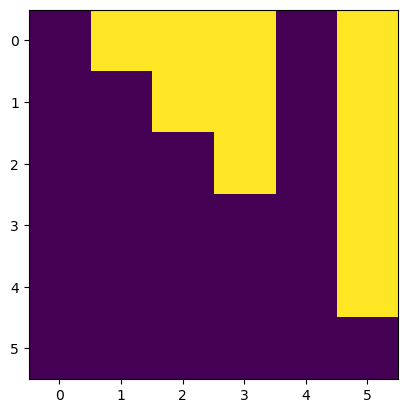

In [ ]:
plt.imshow(~maskTrans.attn.detach().cpu(), cmap='viridis', interpolation='nearest')
m_length//4

### Debug Cond

#### Generate Cond

In [ ]:
@torch.no_grad()
@eval_decorator
def generate(self,
                conds,
                m_lens,
                timesteps: int,
                cond_scale: int,
                temperature=1,
                topk_filter_thres=0.9,
                gsample=False,
                force_mask=False
                ):
    # print(self.opt.num_quantizers)
    # assert len(timesteps) >= len(cond_scales) == self.opt.num_quantizers
    timesteps = 5

    with torch.no_grad():
        cond_vector = self.encode_text(conds)
    is_softmax = True
    seq_len = 49 #max(m_lens)
    GT_LEN = True


    padding_mask = ~lengths_to_mask(m_lens, seq_len+1)
    # ids = torch.where(padding_mask, self.pad_id, self.mask_id)
    ids = torch.ones_like(padding_mask) * self.pad_id
    ids = ids.scatter(-1, m_lens[..., None], self.end_id)
    scores = torch.where(padding_mask, 1e5, 0.)
    for timestep, steps_until_x0 in zip(torch.linspace(0, 1, timesteps, device=m_lens.device), reversed(range(timesteps))):
        # if steps_until_x0 == 0:
        #     break
        rand_mask_prob = self.noise_schedule(timestep)
        num_token_masked = torch.round(rand_mask_prob * m_lens).clamp(min=1)
        sorted_indices = scores.argsort( dim=1)
        ranks = sorted_indices.argsort(dim=1)  # (b, k), rank[i, j] = the rank (0: lowest) of scores[i, j] on dim=1
        is_mask = (ranks < num_token_masked.unsqueeze(-1))
        cons_pos = ((~is_mask * ~padding_mask) + (ids==self.end_id)) > 0
        cond_ids = torch.where(cons_pos, ids, self.pad_id).clone()

        # ids = torch.where(is_mask, self.pad_id, ids)
        ids, scores = self.gen_one(ids, cond_vector, seq_len, m_lens, cond_ids, GT_LEN, cond_scale)
        ids[cons_pos] = cond_ids[cons_pos]

        scores = torch.cat([scores, torch.ones(scores.shape[0], 1, device=ids.device)*1e5], dim=1)
        
        # nocond_nopad_pos = ((is_mask * ~padding_mask) + (ids==self.end_id)) > 0
        # print(scores[0][nocond_nopad_pos[0]])

        scores = scores.masked_fill(~is_mask, 1e5)
    return ids

def gen_one(self, idx, cond_vector, seq_len, m_lens, cond_idx, GT_LEN, cond_scale):
    probs_all = []
    idx = idx.clone()
    for k in range(seq_len):
        logits = self.forward_with_cond_scale(idx, cond_vector=cond_vector,
                                                padding_mask=None,
                                                cond_scale=cond_scale,
                                                force_mask=False,
                                                cond_idx=cond_idx)
        # logits = top_k(logits[..., -1], topk_filter_thres, dim=-1)
        logits = logits[..., k]
        # if GT_LEN:
        #     logits = logits[..., :-1] # don't predict end token
        filtered_logits = top_k(logits, thres=.9, dim=-1)
        probs = F.softmax(filtered_logits, dim=1)
        dist = Categorical(probs)
        current_idx = dist.sample()
        current_idx = current_idx.unsqueeze(-1)
        current_probs = torch.gather(probs, 1, current_idx)
        probs_all.append(current_probs)
        idx[:, k:k+1] = current_idx
    idx = idx.scatter(-1, m_lens[..., None], self.end_id)
    return idx, torch.cat(probs_all, dim=1)

#### Rand Cond

In [ ]:
@torch.no_grad()
@eval_decorator
def generate(self,
                conds,
                m_lens,
                timesteps: int,
                cond_scale: int,
                temperature=1,
                topk_filter_thres=0.9,
                gsample=False,
                force_mask=False,
                temp=None
                ):
    # print(self.opt.num_quantizers)
    # assert len(timesteps) >= len(cond_scales) == self.opt.num_quantizers
    timesteps = 1

    with torch.no_grad():
        cond_vector = self.encode_text(conds)
    is_softmax = True
    seq_len = 49 #max(m_lens)
    GT_LEN = True


    padding_mask = ~lengths_to_mask(m_lens, seq_len+1)
    # ids = torch.where(padding_mask, self.pad_id, self.mask_id)
    ids = torch.ones_like(padding_mask) * self.pad_id

    ids = torch.cat([temp, torch.ones(ids.shape[0], 1, device=ids.device)*self.pad_id], dim=1).long()
    ids = ids.scatter(-1, m_lens[..., None], self.end_id)
    mask_rid = torch.bernoulli(np.random.rand(1)[0]*.5 * torch.ones(ids.shape, device=ids.device)) > 0
    ids = torch.where(mask_rid*~padding_mask, self.pad_id, ids)

    scores = torch.where(padding_mask, 1e5, 0.)
    for timestep, steps_until_x0 in zip(torch.linspace(0, 1, timesteps, device=m_lens.device), reversed(range(timesteps))):
        # if steps_until_x0 == 0:
        #     break
        rand_mask_prob = self.noise_schedule(timestep)
        num_token_masked = torch.round(rand_mask_prob * m_lens).clamp(min=1)
        sorted_indices = scores.argsort( dim=1)
        ranks = sorted_indices.argsort(dim=1)  # (b, k), rank[i, j] = the rank (0: lowest) of scores[i, j] on dim=1
        is_mask = (ids==self.pad_id)
        cons_pos = ((~is_mask * ~padding_mask) + (ids==self.end_id)) > 0
        cond_ids = torch.where(cons_pos, ids, self.pad_id).clone()

        # ids = torch.where(is_mask, self.pad_id, ids)
        ids, scores = self.gen_one(ids, cond_vector, seq_len, m_lens, cond_ids, GT_LEN, cond_scale)
        ids[cons_pos] = cond_ids[cons_pos]

        scores = torch.cat([scores, torch.ones(scores.shape[0], 1, device=ids.device)*1e5], dim=1)
        
        # nocond_nopad_pos = ((is_mask * ~padding_mask) + (ids==self.end_id)) > 0
        # print(scores[0][nocond_nopad_pos[0]])

        scores = scores.masked_fill(~is_mask, 1e5)
    return ids

#### cond last half

In [ ]:
@torch.no_grad()
@eval_decorator
def generate(self,
                conds,
                m_lens,
                timesteps: int,
                cond_scale: int,
                temperature=1,
                topk_filter_thres=0.9,
                gsample=False,
                force_mask=False,
                temp=None
                ):
    # print(self.opt.num_quantizers)
    # assert len(timesteps) >= len(cond_scales) == self.opt.num_quantizers
    timesteps = 1

    with torch.no_grad():
        cond_vector = self.encode_text(conds)
    is_softmax = True
    seq_len = 49 #max(m_lens)
    GT_LEN = True


    padding_mask = ~lengths_to_mask(m_lens, seq_len+1)
    # ids = torch.where(padding_mask, self.pad_id, self.mask_id)
    ids = torch.ones_like(padding_mask) * self.pad_id

    ids = torch.cat([temp, torch.ones(ids.shape[0], 1, device=ids.device)*self.pad_id], dim=1).long()
    ids = ids.scatter(-1, m_lens[..., None], self.end_id)
    mask_rid = lengths_to_mask( (m_lens/2).int(), seq_len+1)
    id_with_end = lengths_to_mask(m_lens+1, seq_len+1)
    ids = torch.where(~mask_rid*id_with_end, ids, self.pad_id)

    scores = torch.where(padding_mask, 1e5, 0.)
    for timestep, steps_until_x0 in zip(torch.linspace(0, 1, timesteps, device=m_lens.device), reversed(range(timesteps))):
        # if steps_until_x0 == 0:
        #     break
        rand_mask_prob = self.noise_schedule(timestep)
        num_token_masked = torch.round(rand_mask_prob * m_lens).clamp(min=1)
        sorted_indices = scores.argsort( dim=1)
        ranks = sorted_indices.argsort(dim=1)  # (b, k), rank[i, j] = the rank (0: lowest) of scores[i, j] on dim=1
        is_mask = (ids==self.pad_id)
        cons_pos = ((~is_mask * ~padding_mask) + (ids==self.end_id)) > 0
        cond_ids = torch.where(cons_pos, ids, self.pad_id).clone()

        # ids = torch.where(is_mask, self.pad_id, ids)
        ids, scores = self.gen_one(ids, cond_vector, seq_len, m_lens, cond_ids, GT_LEN, cond_scale)
        ids[cons_pos] = cond_ids[cons_pos]

        scores = torch.cat([scores, torch.ones(scores.shape[0], 1, device=ids.device)*1e5], dim=1)
        
        # nocond_nopad_pos = ((is_mask * ~padding_mask) + (ids==self.end_id)) > 0
        # print(scores[0][nocond_nopad_pos[0]])

        scores = scores.masked_fill(~is_mask, 1e5)
    return ids

#### Cond first half

In [ ]:
@torch.no_grad()
@eval_decorator
def generate(self,
                conds,
                m_lens,
                timesteps: int,
                cond_scale: int,
                temperature=1,
                topk_filter_thres=0.9,
                gsample=False,
                force_mask=False,
                temp=None
                ):
    # print(self.opt.num_quantizers)
    # assert len(timesteps) >= len(cond_scales) == self.opt.num_quantizers
    timesteps = 1

    with torch.no_grad():
        cond_vector = self.encode_text(conds)
    is_softmax = True
    seq_len = 49 #max(m_lens)
    GT_LEN = True


    padding_mask = ~lengths_to_mask(m_lens, seq_len+1)
    # ids = torch.where(padding_mask, self.pad_id, self.mask_id)
    ids = torch.ones_like(padding_mask) * self.pad_id

    ids = torch.cat([temp, torch.ones(ids.shape[0], 1, device=ids.device)*self.pad_id], dim=1).long()
    ids = ids.scatter(-1, m_lens[..., None], self.end_id)
    mask_rid = lengths_to_mask( (m_lens*1/2).int(), seq_len+1)
    # id_with_end = lengths_to_mask(m_lens+1, seq_len+1)
    ids = torch.where(mask_rid + (ids==self.end_id), ids, self.pad_id)

    scores = torch.where(padding_mask, 1e5, 0.)
    for timestep, steps_until_x0 in zip(torch.linspace(0, 1, timesteps, device=m_lens.device), reversed(range(timesteps))):
        # if steps_until_x0 == 0:
        #     break
        rand_mask_prob = self.noise_schedule(timestep)
        num_token_masked = torch.round(rand_mask_prob * m_lens).clamp(min=1)
        sorted_indices = scores.argsort( dim=1)
        ranks = sorted_indices.argsort(dim=1)  # (b, k), rank[i, j] = the rank (0: lowest) of scores[i, j] on dim=1
        is_mask = (ids==self.pad_id)
        cons_pos = ((~is_mask * ~padding_mask) + (ids==self.end_id)) > 0
        cond_ids = torch.where(cons_pos, ids, self.pad_id).clone()

        # ids = torch.where(is_mask, self.pad_id, ids)
        ids, scores = self.gen_one(ids, cond_vector, seq_len, m_lens, cond_ids, GT_LEN, cond_scale)
        ids[cons_pos] = cond_ids[cons_pos]

        scores = torch.cat([scores, torch.ones(scores.shape[0], 1, device=ids.device)*1e5], dim=1)
        
        # nocond_nopad_pos = ((is_mask * ~padding_mask) + (ids==self.end_id)) > 0
        # print(scores[0][nocond_nopad_pos[0]])

        scores = scores.masked_fill(~is_mask, 1e5)
    return ids

### Repredict Iteration

#### Repredict & No pad

In [ ]:
@torch.no_grad()
@eval_decorator
def generate(self,
                conds,
                m_lens,
                timesteps: int,
                cond_scale: int,
                temperature=1,
                topk_filter_thres=0.9,
                gsample=False,
                force_mask=False
                ):
    # print(self.opt.num_quantizers)
    # assert len(timesteps) >= len(cond_scales) == self.opt.num_quantizers
    with torch.no_grad():
        cond_vector = self.encode_text(conds)
    is_softmax = True
    seq_len = 49 #max(m_lens)


    # padding_mask = ~lengths_to_mask(m_lens, seq_len+1)
    # ids = torch.ones_like(padding_mask) * self.pad_id
    # ids = ids.scatter(-1, m_lens[..., None], self.end_id)
    # scores = torch.where(padding_mask, 1e5, 0.)
    ids = torch.ones((len(conds), seq_len+1), dtype=torch.long, device=m_lens.device) * self.pad_id
    ids, scores = self.gen_one(ids, cond_vector, seq_len, cond_idx=None, cond_scale=cond_scale)
    ids, pred_len = self.pad_after_end(ids)
    padding_mask = ~lengths_to_mask(pred_len, seq_len+1)
    ids = ids.scatter(-1, pred_len[..., None], self.end_id)
    scores = torch.where(padding_mask, 1e5, 0.)
    for p in [.5, .25, .125]:
        num_token_masked = torch.round(p * pred_len).clamp(min=1)
        sorted_indices = scores.argsort( dim=1)
        ranks = sorted_indices.argsort(dim=1)  # (b, k), rank[i, j] = the rank (0: lowest) of scores[i, j] on dim=1
        is_mask = (ranks < num_token_masked.unsqueeze(-1))
        cons_pos = ((~is_mask * ~padding_mask) + (ids==self.end_id)) > 0
        cond_idx = torch.where(cons_pos, ids, self.pad_id).clone()
        print(cond_idx[0])

        ids, scores = self.gen_one(ids, cond_vector, seq_len, cond_idx, cond_scale=cond_scale)
        ids[cons_pos] = cond_idx[cons_pos]
        
        scores = torch.cat([scores, torch.ones(scores.shape[0], 1, device=ids.device)*1e5], dim=1)
        scores = scores.masked_fill(~is_mask, 1e5)
    return ids

def gen_one(self, idx, cond_vector, seq_len, cond_idx, cond_scale):
    probs_all = []
    idx = idx.clone()
    for k in range(seq_len):
        logits = self.forward_with_cond_scale(idx, cond_vector=cond_vector,
                                                padding_mask=None,
                                                cond_scale=cond_scale,
                                                cond_idx=cond_idx)
        # logits = top_k(logits[..., -1], topk_filter_thres, dim=-1)
        logits = logits[..., k]
        probs = F.softmax(logits, dim=1)
        dist = Categorical(probs)
        current_idx = dist.sample()
        current_idx = current_idx.unsqueeze(-1)
        current_probs = torch.gather(probs, 1, current_idx)
        probs_all.append(current_probs)
        idx[:, k:k+1] = current_idx
    return idx, torch.cat(probs_all, dim=1)

#### No Repredict & pad

In [ ]:
@torch.no_grad()
@eval_decorator
def generate(self,
                conds,
                m_lens,
                timesteps: int,
                cond_scale: int,
                temperature=1,
                topk_filter_thres=0.9,
                gsample=False,
                force_mask=False
                ):
    # print(self.opt.num_quantizers)
    # assert len(timesteps) >= len(cond_scales) == self.opt.num_quantizers
    with torch.no_grad():
        cond_vector = self.encode_text(conds)
    is_softmax = True
    seq_len = 49 #max(m_lens)


    # padding_mask = ~lengths_to_mask(m_lens, seq_len+1)
    # ids = torch.ones_like(padding_mask) * self.pad_id
    # ids = ids.scatter(-1, m_lens[..., None], self.end_id)
    # scores = torch.where(padding_mask, 1e5, 0.)
    ids = torch.ones((len(conds), seq_len+1), dtype=torch.long, device=m_lens.device) * self.pad_id
    ids, scores = self.gen_one(ids, cond_vector, seq_len, cond_idx=None, cond_scale=cond_scale)
    ids, pred_len = self.pad_after_end(ids)
    padding_mask = ~lengths_to_mask(pred_len, seq_len+1)
    ids = ids.scatter(-1, pred_len[..., None], self.end_id)
    scores = torch.where(padding_mask, 1e5, 0.)
    for p in [.5, .25, .125]:
        num_token_masked = torch.round(p * pred_len).clamp(min=1)
        sorted_indices = scores.argsort( dim=1)
        ranks = sorted_indices.argsort(dim=1)  # (b, k), rank[i, j] = the rank (0: lowest) of scores[i, j] on dim=1
        is_mask = (ranks < num_token_masked.unsqueeze(-1))
        cons_pos = ((~is_mask * ~padding_mask) + (ids==self.end_id)) > 0
        cond_idx = torch.where(cons_pos, ids, self.pad_id).clone()

        ids, scores = self.gen_one(ids, cond_vector, seq_len, cond_idx, cond_scale=cond_scale)
        ids = torch.where(padding_mask, self.pad_id, ids)
        ids[cons_pos] = cond_idx[cons_pos]
        
        scores = torch.cat([scores, torch.ones(scores.shape[0], 1, device=ids.device)*1e5], dim=1)
        scores = scores.masked_fill(~is_mask, 1e5)
    return ids

def gen_one(self, idx, cond_vector, seq_len, cond_idx, cond_scale):
    probs_all = []
    idx = idx.clone()
    for k in range(seq_len):
        logits = self.forward_with_cond_scale(idx, cond_vector=cond_vector,
                                                padding_mask=None,
                                                cond_scale=cond_scale,
                                                cond_idx=cond_idx)
        # logits = top_k(logits[..., -1], topk_filter_thres, dim=-1)
        logits = logits[..., k]
        probs = F.softmax(logits, dim=1)
        dist = Categorical(probs)
        current_idx = dist.sample()
        current_idx = current_idx.unsqueeze(-1)
        current_probs = torch.gather(probs, 1, current_idx)
        probs_all.append(current_probs)
        idx[:, k:k+1] = current_idx
        if cond_idx is not None:
            cons_pos = cond_idx != self.pad_id
            idx[cons_pos] = cond_idx[cons_pos]
    return idx, torch.cat(probs_all, dim=1)

#### Repredict all

In [ ]:
@torch.no_grad()
@eval_decorator
def generate(self,
                conds,
                m_lens,
                timesteps: int,
                cond_scale: int,
                temperature=1,
                topk_filter_thres=0.9,
                gsample=False,
                force_mask=False
                ):
    # print(self.opt.num_quantizers)
    # assert len(timesteps) >= len(cond_scales) == self.opt.num_quantizers
    with torch.no_grad():
        cond_vector = self.encode_text(conds)
    is_softmax = True
    seq_len = 50 #max(m_lens)


    # padding_mask = ~lengths_to_mask(m_lens, seq_len+1)
    # ids = torch.ones_like(padding_mask) * self.pad_id
    # ids = ids.scatter(-1, m_lens[..., None], self.end_id)
    # scores = torch.where(padding_mask, 1e5, 0.)
    ids = torch.ones((len(conds), seq_len), dtype=torch.long, device=m_lens.device) * self.pad_id
    ids, scores = self.gen_one(ids, cond_vector, seq_len, cond_idx=None, cond_scale=cond_scale)
    # padding_mask = ~lengths_to_mask(pred_len, seq_len+1)
    # ids = ids.scatter(-1, pred_len[..., None], self.end_id)
    # scores = torch.where(padding_mask, 1e5, 0.)
    for p in [.5]:
        _, pred_len = self.pad_after_end(ids)
        padding_mask = ~lengths_to_mask(pred_len+1, seq_len)
        scores = scores.masked_fill(padding_mask, 1e5)
        
        num_token_masked = torch.round(p * (pred_len+1)).clamp(min=1)
        sorted_indices = scores.argsort( dim=1)
        ranks = sorted_indices.argsort(dim=1)  # (b, k), rank[i, j] = the rank (0: lowest) of scores[i, j] on dim=1
        is_mask = (ranks < num_token_masked.unsqueeze(-1))
        cons_pos = (~is_mask * ~padding_mask) #( + (ids==self.end_id)) > 0
        cond_idx = torch.where(cons_pos, ids, self.pad_id).clone()
        ids, scores = self.gen_one(ids, cond_vector, seq_len, cond_idx, cond_scale=cond_scale)
        # ids = torch.where(padding_mask, self.pad_id, ids)
        # ids[cons_pos] = cond_idx[cons_pos]
        
        # scores = torch.cat([scores, torch.ones(scores.shape[0], 1, device=ids.device)*1e5], dim=1)
        # scores = scores.masked_fill(~is_mask, 1e5)
    return ids

def gen_one(self, idx, cond_vector, seq_len, cond_idx, cond_scale):
    probs_all = []
    idx = idx.clone()
    for k in range(seq_len):
        logits = self.forward_with_cond_scale(idx, cond_vector=cond_vector,
                                                padding_mask=None,
                                                cond_scale=cond_scale,
                                                cond_idx=cond_idx)
        # logits = top_k(logits[..., -1], topk_filter_thres, dim=-1)
        logits = logits[..., k]
        probs = F.softmax(logits, dim=1)
        dist = Categorical(probs)
        current_idx = dist.sample()
        current_idx = current_idx.unsqueeze(-1)
        current_probs = torch.gather(probs, 1, current_idx)
        probs_all.append(current_probs)
        idx[:, k:k+1] = current_idx
        # if cond_idx is not None:
        #     cons_pos = cond_idx != self.pad_id
        #     idx[cons_pos] = cond_idx[cons_pos]
    return idx, torch.cat(probs_all, dim=1)

#### Repredict With End Cond

In [ ]:
@torch.no_grad()
@eval_decorator
def generate(self,
                conds,
                m_lens,
                timesteps: int,
                cond_scale: int,
                temperature=1,
                topk_filter_thres=0.9,
                gsample=False,
                force_mask=False
                ):
    with torch.no_grad():
        cond_vector = self.encode_text(conds)
    is_softmax = True
    seq_len = 50 #max(m_lens)
    ids = torch.ones((len(conds), seq_len), dtype=torch.long, device=m_lens.device) * self.pad_id
    ids, scores = self.gen_one(ids, cond_vector, seq_len, cond_idx=None, cond_scale=cond_scale)
    for p in [.5]:
        ids, pred_len = self.pad_after_end(ids)
        padding_mask = ~lengths_to_mask(pred_len, seq_len)
        scores = scores.masked_fill(padding_mask, 1e5)
        
        num_token_masked = torch.round(p * (pred_len)).clamp(min=1)
        sorted_indices = scores.argsort( dim=1)
        ranks = sorted_indices.argsort(dim=1)  # (b, k), rank[i, j] = the rank (0: lowest) of scores[i, j] on dim=1
        is_mask = (ranks < num_token_masked.unsqueeze(-1))
        cons_pos = ((~is_mask * ~padding_mask) + (ids==self.end_id)) > 0
        cond_idx = torch.where(cons_pos, ids, self.pad_id).clone()
        ids, scores = self.gen_one(ids, cond_vector, seq_len, cond_idx, cond_scale=cond_scale)
    return ids

def gen_one(self, idx, cond_vector, seq_len, cond_idx, cond_scale):
    probs_all = []
    idx = idx.clone()
    for k in range(seq_len):
        logits = self.forward_with_cond_scale(idx, cond_vector=cond_vector,
                                                padding_mask=None,
                                                cond_scale=cond_scale,
                                                cond_idx=cond_idx)
        # logits = top_k(logits[..., -1], topk_filter_thres, dim=-1)
        logits = logits[..., k]
        probs = F.softmax(logits, dim=1)
        dist = Categorical(probs)
        current_idx = dist.sample()
        current_idx = current_idx.unsqueeze(-1)
        current_probs = torch.gather(probs, 1, current_idx)
        probs_all.append(current_probs)
        idx[:, k:k+1] = current_idx
        # if cond_idx is not None:
        #     cons_pos = cond_idx != self.pad_id
        #     idx[cons_pos] = cond_idx[cons_pos]
    return idx, torch.cat(probs_all, dim=1)

def pad_after_end(self, xs):
    # (b, 50)
    xs[:, -1] = self.end_id # mask sure there always be end tokens
    # prevent case that length is 0 by move end_id to the second index and fill up "0" in the first index
    pred_end_at_first = xs[:, 0] >= self.end_id
    xs[:, 0][pred_end_at_first] = 0
    xs[:, 1][pred_end_at_first] = self.end_id
    
    pred_len = (torch.ones(xs.shape[0], device=xs.device) * (xs.shape[1] + 1)).long()
    # From https://discuss.pytorch.org/t/first-nonzero-index/24769/3
    mask_max_values, max_indices = torch.max(xs >= self.end_id, dim=1)
    max_indices[~mask_max_values] = -1
    pred_len[max_indices>=0] = max_indices[max_indices>=0]
    motion_mask = lengths_to_mask(pred_len+1, xs.shape[1])
    xs = xs * motion_mask + self.pad_id * ~motion_mask
    return xs, pred_len

#### 2nd Iter with Confidence > .8

In [ ]:
@torch.no_grad()
@eval_decorator
def generate(self,
                conds,
                m_lens,
                timesteps: int,
                cond_scale: int,
                temperature=1,
                topk_filter_thres=0.9,
                gsample=False,
                force_mask=False
                ):
    # print(self.opt.num_quantizers)
    # assert len(timesteps) >= len(cond_scales) == self.opt.num_quantizers


    with torch.no_grad():
        cond_vector = self.encode_text(conds)
    is_softmax = True
    seq_len = 49 #max(m_lens)


    # padding_mask = ~lengths_to_mask(m_lens, seq_len+1)
    # ids = torch.ones_like(padding_mask) * self.pad_id
    # ids = ids.scatter(-1, m_lens[..., None], self.end_id)
    # scores = torch.where(padding_mask, 1e5, 0.)
    ids = torch.ones((len(conds), seq_len+1), dtype=torch.long, device=m_lens.device) * self.pad_id
    ids, scores = self.gen_one(ids, cond_vector, seq_len, cond_idx=None, cond_scale=cond_scale)
    ids, pred_len = self.pad_after_end(ids)
    padding_mask = ~lengths_to_mask(pred_len, seq_len+1)
    ids = ids.scatter(-1, pred_len[..., None], self.end_id)
    for p in [.5]:
        scores = torch.cat([scores, torch.zeros(scores.shape[0], 1, device=ids.device)], dim=1)
        scores = scores.masked_fill(padding_mask, 0)
        cons_pos = (((scores > .8) * ~padding_mask) + (ids==self.end_id)) > 0
        cond_idx = torch.where(cons_pos, ids, self.pad_id).clone()
        ids, scores = self.gen_one(ids, cond_vector, seq_len, cond_idx, cond_scale=cond_scale)
        ids = torch.where(padding_mask, self.pad_id, ids)
        ids[cons_pos] = cond_idx[cons_pos]

        scores = torch.cat([scores, torch.zeros(scores.shape[0], 1, device=ids.device)*1e5], dim=1)
        scores = scores.masked_fill(padding_mask, 0)
    return ids

#### Repredict only less conf

In [ ]:
m_pos = ~padding_mask
conf = (scores*m_pos).sum(-1)/m_pos.sum(-1)
norepred = conf > 0 # ~is_mask
_ids = ids


.....
ids[norepred] = _ids[norepred]